In [1]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [2]:
# transformations
transform = T.Compose(
    [
        T.ToTensor(),
        T.RandomHorizontalFlip(p=0.5),
        T.Normalize(0.5, 0.5),
    ]
)

# import the data and simultaneously apply the transform
trainset = tv.datasets.FashionMNIST(
    root="../Datasets/", train=True, download=True, transform=transform
)
devtest = tv.datasets.FashionMNIST(
    root="../Datasets/", train=False, download=True, transform=transform
)

# split the devtest into two separate sets
randidx = np.random.permutation(10000)  # a random permutation of indices
devset = Subset(devtest, randidx[:6000])  # Subset for devset
testset = Subset(devtest, randidx[6000:])  # Subset for test

# transform to dataloaders
batchsize = 32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True, generator=torch.Generator(device=device))
dev_loader = DataLoader(devset, batch_size=len(devset), generator=torch.Generator(device=device))
test_loader = DataLoader(testset, batch_size=len(testset), generator=torch.Generator(device=device))

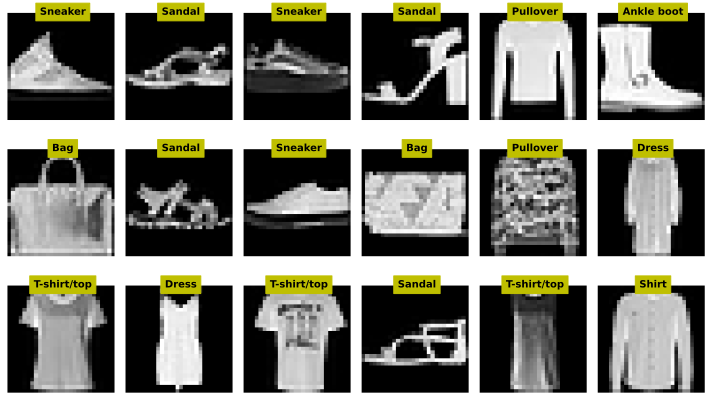

In [3]:
# inspect a few random images
X, y = next(iter(test_loader))

fig, axs = plt.subplots(3, 6, figsize=(10, 6))

for i, ax in enumerate(axs.flatten()):

    # extract that image
    pic = torch.squeeze(X.data[i])
    pic = pic / 2 + 0.5  # undo normalization

    # and its label
    label = trainset.classes[y[i]]

    # and show!
    ax.imshow(pic, cmap="gray")
    ax.text(
        14, 0, label, ha="center", fontweight="bold", color="k", backgroundcolor="y"
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

In [5]:
def createFMNISTAENet(print_toggle=False):
    class fmnistNet(nn.Module):

        def __init__(self, print_toggle):
            super().__init__()
            self.print = print_toggle

            # Encode Convolution layers
            self.encconv1 = nn.Conv2d(1, 16, 3, padding=1, stride = 2)
            self.encconv2 = nn.Conv2d(16, 32, 3, padding=1, stride=2)

            # Decode convolution layer
            self.decconv1 = nn.ConstantPad2d(32, 16, 4, padding=1, stride=2)
            self.decconv2 = nn.ConstantPad2d(16, 1, 4, padding=1, stride=2)

        def forward(self, x):

            if self.print: print(f'Input: {list(x.shape)}')
            
            # first encoder layer
            x = F.leaky_relu(self.encconv1(x))
            if self.print: print(f'First encoder layer: {list(x.shape)}')

            # second encoder layer
            x = F.leaky_relu(self.encconv2(x))
            if self.print: print(f'Second encoder layer: {list(x.shape)}')

            # first decoder layer
            x = F.leaky_relu(self.decconv1(x))
            if self.print: print(f'First decoder layer: {list(x.shape)}')

            # second decoder layer
            x = F.leaky_relu(self.decconv2(x))
            if self.print: print(f'Second decoder layer: {list(x.shape)}')

            return x  

    # Model instance
    net = fmnistNet(print_toggle)

    # Loss Function
    lossFun = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossFun, optimizer